In [1]:
import pandas as pd
import numpy as np
import surprise
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
import gensim.models.keyedvectors as word2vec
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import umap
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as rmse
import xgboost
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

C:\Users\vdtri\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfs = []
for i in tqdm(range(1, 6)):
    dfs.append(pd.read_excel(f"dataset/{i}.xls", header=None))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.19s/it]


In [3]:
df = pd.concat(dfs, axis=0)
df = df[range(1, df.shape[1])]
df[df == 99] = None
df = (df + 10) * 4 /20 + 1
df.fillna(0, inplace=True)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,149,150,151,152,153,154,155,156,157,158
0,1.436,4.758,1.068,1.368,1.496,1.300,1.030,3.834,1.204,2.048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.816,2.942,4.272,3.874,2.524,1.068,2.854,1.932,4.776,4.844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.000,0.000,0.000,4.806,4.854,4.806,4.854,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000,4.670,0.000,0.000,3.360,4.632,2.436,4.242,0.000,3.368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.700,3.922,2.166,1.922,3.272,3.320,4.408,3.922,2.912,4.146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df = df.reset_index(drop=True)
df.to_csv(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\dataset\dataset.csv", index_label='index')

In [5]:
lemmatizer = WordNetLemmatizer()

orig_texts = pd.read_excel("dataset/Dataset4JokeSet.xlsx", header=None)
texts = pd.read_excel("dataset/Dataset4JokeSet.xlsx", header=None)
texts = texts.applymap(lambda x: x.lower())
texts = texts.applymap(lambda x: re.sub("[^a-zA-Z]", " ", x))
texts.head()

,0
0,a man visits the doctor the doctor says i ha...
1,this couple had an excellent relationship goin...
2,q what s feet long and has teeth a ...
3,q what s the difference between a man and a t...
4,q what s o j simpson s internet address a...


In [6]:
texts = texts.applymap(lambda x: ' '.join(map(lemmatizer.lemmatize, x.split())))
texts = texts.applymap(lambda x: ' '.join(map(lambda w: '' if w in stopwords.words('english') or len(w) < 3 else w, x.split())))
texts = texts.applymap(lambda x: re.sub('\s+', ' ', x))
texts.head()

,0
0,man visit doctor doctor say bad news cancer a...
1,couple excellent relationship going one day c...
2,foot long teeth front row willie nelson concert
3,difference man toilet toilet follow around use
4,simpson internet address slash slash backslas...


In [64]:
w2v = word2vec.load_word2vec_format(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\model.bin", binary=True)

In [65]:
lst = []
for i in tqdm(range(158)):
    temp = np.array(list(map(lambda x: w2v[x] if x in w2v.index_to_key else np.full(300, 0), texts.loc[i][0].split())))
    lst.append(np.mean(temp, axis=0))
#lst = np.array(lst)
dim_red_joke = umap.UMAP(n_neighbors=4, n_components=10)
vecs = dim_red_joke.fit_transform(lst)
vec_repr = pd.DataFrame({'vec': lst})

100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [00:02<00:00, 63.08it/s]


In [66]:
# with open(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\models\dim_red_joke", 'wb') as f:
#     pickle.dump(dim_red_joke, f)

In [67]:
# store_vecs = []
# for val in vecs:
#     store_vecs.append(','.join(map(str, val)))
# sv = pd.DataFrame({'vec':store_vecs})
# sv.to_csv(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\dataset\joke_vecs.csv", index_label="index")

In [5]:
sv = pd.read_csv(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\dataset\joke_vecs.csv", index_col='index')
big_vec = []
for i in sv.index:
    big_vec.append(list(map(lambda x: float(x), sv.loc[i].values[0].split(','))))
sv.head()

,vec
index,
0,"9.215792,7.1518307,7.333948,7.554291,6.093221,..."
1,"9.095252,7.5165243,7.2224517,7.3640776,5.60667..."
2,"10.893514,8.768776,6.6913805,7.9893293,5.25730..."
3,"9.589137,8.77962,6.6775923,8.362339,6.0213175,..."
4,"10.146294,8.207376,6.2449346,8.142194,5.657114..."


In [6]:
vecs = np.asarray(big_vec)
vecs.shape

(158, 10)

In [12]:
dred = umap.UMAP(n_neighbors=3, n_components=2)
vec_for_analyse = dred.fit_transform(lst)

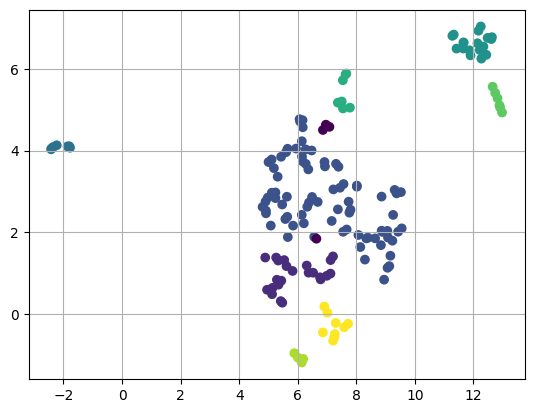

In [13]:
from sklearn.cluster import DBSCAN
import numpy as np
clustering = DBSCAN(eps=0.55, min_samples=4).fit(vec_for_analyse)
cll = clustering.labels_

colors = []
for ind, val in enumerate(vec_for_analyse):
    colors.append(cll[ind] + 1)
colors = np.asarray(colors)
colors = colors / len(colors)
plt.scatter(vec_for_analyse[:, 0], vec_for_analyse[:, 1], c=colors)
plt.grid(True)

In [57]:
sim = cdist([vec_repr.iloc[79, 0]], vec_repr['vec'].values.tolist(), metric='cosine')
#sim = cdist([u[28]], u)

In [58]:
sorted(zip(range(158), sim.ravel()), key=lambda x: x[1])[:6]

[(79, 0.0),
 (5, 0.2236960606894659),
 (55, 0.26067136403885427),
 (147, 0.27892148260515703),
 (26, 0.28117752688386555),
 (127, 0.2843839715436858)]

In [59]:
orig_texts.iloc[79][0]

'Hillary, Bill Clinton and the Pope are sitting together on an airplane.  Bill says "I could throw one thousand dollar bill out of this plane and make one person very happy."  Hillary says "I could throw 10 hundred dollar bills out of the plane and make 10 people very happy."  The Pope chips in and says "I could throw Bill out of the airplane and make the whole  country happy."'

In [60]:
orig_texts.iloc[147][0]

'Recently a teacher, a garbage collector, and a lawyer wound up together at the Pearly Gates. St. Peter informed them that in order to get into Heaven, they would each have to answer one question. St. Peter addressed the teacher and asked, "What was the name of the ship that crashed into the iceberg? They just made a movie about it." The teacher answered quickly, "That would be the Titanic." St. Peter let him through the gate. St. Peter turned to the garbage man and, figuring Heaven didn\'t really need all the odors that this guy would bring with him, decided to make the question a little harder: "How many people died on the ship?" Fortunately for him, the trash man had just seen the movie. "1,228," he answered. "That\'s right! You may enter." St. Peter turned to the lawyer: "Name them."'

# User vector

In [18]:
# with open(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\models\dim_red_user", 'wb') as f:
#     pickle.dump(dim_red, f)

In [19]:
# with open(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\models\dim_red_joke", 'wb') as f:
#     pickle.dump(dim_red_joke, f)

In [20]:
# store_vecs = []
# for val in user_vec:
#     store_vecs.append(','.join(map(str, val)))
# sv = pd.DataFrame({'vec':store_vecs})
# sv.to_csv(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\dataset\user_vecs.csv", index_label="index")

In [68]:
del w2v

In [7]:
dataset = []
target = []
# i = 0
# lst = np.asarray(lst)
df = df.astype(np.float16)
for ind, (_, row) in tqdm(enumerate(df.iterrows())):
    # if i == 3:
    #     break
    # i += 1
    # val = vecs[row != 0]
    # dataset.extend(np.concatenate((np.broadcast_to(user_vec[ind], (val.shape[0], user_vec.shape[1])), val), axis=1))
    # target.extend(row[row != 0])
    val = vecs[row != 0].astype(np.float16)
    # value = np.concatenate((np.broadcast_to(df.iloc[ind], (val.shape[0], df.shape[1])), val), axis=1)
    # print(value.shape)
    dataset.extend(np.concatenate((np.broadcast_to(df.iloc[ind], (val.shape[0], df.shape[1])), val), axis=1))
    target.extend(row[row != 0])

136025it [00:59, 2299.11it/s]


In [8]:
dataset = np.asarray(dataset)
target = np.asarray(target)

In [9]:
dataset.shape, target.shape

((6085219, 168), (6085219,))

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.4)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3)

In [73]:
X_train_meta, X_test, y_train_meta, y_test = train_test_split(X_test, y_test, test_size=0.3)

In [74]:
X_train, X_tune, y_train, y_tune = train_test_split(X_train, y_train, test_size=0.1)

In [40]:
params = {'alpha': np.linspace(1e-6, 1e-1, 10)}
gs = GridSearchCV(Ridge(),
                      param_grid=params,
                      scoring='neg_mean_squared_error',
                      verbose=1,
                      cv=3)
gs.fit(X_tune, y_tune)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': array([1.0000e-06, 1.1112e-02, 2.2223e-02, 3.3334e-02, 4.4445e-02,
       5.5556e-02, 6.6667e-02, 7.7778e-02, 8.8889e-02, 1.0000e-01])},
             scoring='neg_mean_squared_error', verbose=1)

In [41]:
gs.best_params_, gs.best_score_

({'alpha': 0.033334}, -0.915946368656039)

In [29]:
reg1 = Ridge(alpha=0.033334)
reg1.fit(X_train, y_train)
rmse(y_test, reg1.predict(X_test))

0.9320947675193284

In [30]:
r2_score(y_test, reg1.predict(X_test))

0.17257679191046627

In [31]:
# with open(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\models\reg1", 'wb') as f:
#     pickle.dump(reg1, f)

In [45]:
import xgboost

params = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 4, 5]
}
gs = GridSearchCV(xgboost.XGBRegressor(),
                      param_grid=params,
                      scoring='neg_mean_squared_error',
                      verbose=2,
                      cv=3)
gs.fit(X_tune, y_tune)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .......................max_depth=3, n_estimators=50; total time=  14.9s
[CV] END .......................max_depth=3, n_estimators=50; total time=  16.3s
[CV] END .......................max_depth=3, n_estimators=50; total time=  17.1s
[CV] END ......................max_depth=3, n_estimators=100; total time=  31.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=  31.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=  30.9s
[CV] END ......................max_depth=3, n_estimators=200; total time=  59.5s
[CV] END ......................max_depth=3, n_estimators=200; total time=  59.7s
[CV] END ......................max_depth=3, n_estimators=200; total time=  59.6s
[CV] END .......................max_depth=4, n_estimators=50; total time=  21.5s
[CV] END .......................max_depth=4, n_estimators=50; total time=  21.4s
[CV] END .......................max_depth=4, n_es

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [46]:
gs.best_params_, gs.best_score_

({'max_depth': 5, 'n_estimators': 200}, -0.26919474204381305)

In [18]:
import xgboost

reg2 = xgboost.XGBRegressor(n_estimators=200, max_depth=5, verbosity=2, 
                            tree_method="gpu_hist")
reg2.fit(X_train, y_train)
rmse(y_test, reg2.predict(X_test))

0.2654413449409745

In [19]:
r2_score(y_test, reg2.predict(X_test))

0.7643669540435359

In [20]:
# with open(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\models\reg2", 'wb') as f:
#     pickle.dump(reg2, f)

In [ ]:
params = {'max_depth': [i * 2 for i in range(7)]}
gs = GridSearchCV(DecisionTreeRegressor(),
                      param_grid=params,
                      scoring='neg_mean_squared_error',
                      verbose=2,
                      cv=3)
gs.fit(X_tune, y_tune)
gs.best_params_

In [26]:
reg3 = DecisionTreeRegressor(max_depth=10)
reg3.fit(X_train, y_train)
rmse(y_test, reg3.predict(X_test))

0.8589640691403053

In [27]:
r2_score(y_test, reg3.predict(X_test))

0.2374951233625786

In [28]:
# with open(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\models\reg3", 'wb') as f:
#     pickle.dump(reg3, f)

In [41]:
r1 = np.array([reg1.predict(X_train_meta)]).reshape(-1, 1)
r2 = np.array([reg2.predict(X_train_meta)]).reshape(-1, 1)
r3 = np.array([reg3.predict(X_train_meta)]).reshape(-1, 1)
X_meta = np.concatenate((r1, r2, r3), axis=1)

In [42]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_meta, y_test)

LinearRegression()

In [43]:
reg.coef_

array([-0.13178208,  1.24825735, -0.16800728])

In [44]:
# with open(r"C:\Users\vdtri\Documents\Учеба\Рекомендательные системы\proj\models\coef", 'wb') as f:
#     pickle.dump(reg.coef_, f)